Copyright (c) 2024 Agnese Re <agnesere43@gmail.com>\
GitHub account: https://github.com/AgneseRe

In [431]:
# Import libraries
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt

from icecream import ic
from itertools import combinations
from geopy.distance import geodesic
from dataclasses import dataclass

### Read csv and compute distance matrix
Read a comma-separated values (csv) file into DataFrame using *read_csv* function of **pandas** library. The file does not contain any header, the first line already contains the name and geographical coordinates of a city. Columns names are passed explicitly to *names* parameter. Using the *geodesic* function of **geopy** library, the geodesic distance in kilometers between each pair of cities is computed.


In [432]:
CITIES = pd.read_csv("cities/vanuatu.csv", sep = ",", header = None, names = ['Name', 'Lat', 'Long'])
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
        (c1.Lat, c1.Long), (c2.Lat, c2.Long)
    ).km

In [433]:
CITIES.head()   # first 5 rows of the CITIES dataframe

,Name,Lat,Long
0,Isangel,-19.53,169.28
1,Lakatoro,-16.09,167.40
2,Longana,-15.30,168.00
3,Luganville,-15.51,167.15
4,Norsup,-16.07,167.39


In [434]:
CITIES_NAMES, CITY_INDEXES = map(np.array, zip(*[(city['Name'], i) for i, city in CITIES.iterrows()]))

### Data Class and fitness function definition
The data class *Individual* is defined. The *genome* attribute holds an individual's genome. The *fitness* attribute quantifies how well the individual performs with respect to the objective function. Initially, it is set to *None*. The fitness score will be calculate later, after the genome is evaluated.  
*e.g.* If the number of cities for TSP is equal to 8, a possible *Individual* object is ```Individual(genome=array([7, 3, 0, 2, 1, 6, 4, 5]), fitness=np.float64(2306.6849123742595))```.

In [435]:
@dataclass
class Individual:
    genome: np.ndarray
    fitness: float = None

def calculate_fitness(individual: Individual) -> float:
    tot_cost = 0.0
    for c1, c2 in zip(individual.genome, np.concatenate((individual.genome[1:], individual.genome[:1]))):
        tot_cost += DIST_MATRIX[c1, c2]
    return tot_cost

### Greedy Approach
Start from city 0 and move, from time to time, to the *nearest* city. It's an algorithm that leads to immediate cost gain, but becomes awful in the process. It is a fast approach (*e.g.* 8 steps in case of 8 cities), but it leads to an approximate solution.

In [436]:
# At the beginning, no city is visited
visited = np.full(len(CITIES), False)

# Set the starting point and set it to visited
city = 0
visited[city] = True
dist = DIST_MATRIX.copy()

# List to store results
tsp = []
tsp.append(int(city))

while not np.all(visited):
    # Find the minimum cost and the corresponding city among those not yet visited
    closest_cost = np.min([dist[city, adj] for adj in range(len(CITIES)) if not visited[adj] and adj != city])
    closest = np.where(dist[city] == closest_cost)[0][0]    # e.g. (array([7]),) -> tuple first element, array first element
    # Set the found city to visited and add it to the tsp list
    visited[closest] = True
    tsp.append(int(closest))
    # Update city
    city = closest

# Print result
best_path = Individual(tsp)
best_path.fitness = calculate_fitness(best_path)
print(f"{len(CITIES)} cities, shortest tour is {best_path.fitness:.2f} km")
print([str(CITIES_NAMES[index]) for index in tsp])

8 cities, shortest tour is 1475.53 km
['Isangel', 'Vila', 'Lakatoro', 'Norsup', 'Luganville', 'Port Olry', 'Longana', 'Sola']


### Genetic Algorithm

In [437]:
POPULATION_SIZE = 100
population = []

In [438]:
# Initial random solutions
rng = np.random.default_rng()

while len(population) < POPULATION_SIZE:
    new_individual = CITY_INDEXES.copy()
    rng.shuffle(new_individual)
    if tuple(new_individual) not in [tuple(i.genome) for i in population]:
        population.append(Individual(new_individual))

for i in population:
    i.fitness = calculate_fitness(i)

best_path_index = np.argmax([i.fitness for i in population])
print(f"Best path no. {best_path_index} with cost {population[best_path_index].fitness:.2f} km")

Best path no. 92 with cost 2256.60 km


In [439]:
def parent_selection(population: np.ndarray) -> Individual:
    candidates = sorted(np.random.choice(population, 5), key = lambda i: i.fitness)
    return candidates[0]

def swap_mutation(individual: Individual) -> Individual:
    new_individual = copy.deepcopy(individual)
    i1, i2 = np.random.choice(len(individual.genome), 2, replace = False)
    new_individual.genome[i1], new_individual.genome[i2] = new_individual.genome[i2], new_individual.genome[i1]
    new_individual.fitness = calculate_fitness(new_individual)
    return new_individual

def displacement_mutation(individual: Individual) -> Individual:
    genome = individual.genome
    start = np.random.randint(0, len(genome) - 2)   # cut point 1
    end = np.random.randint(start + 1, len(genome) - 1) # cut point 2
    segment = genome[start: end+1]
    genome = np.concatenate((genome[:start], genome[end+1:]))
    random_location = np.random.randint(0, len(genome))
    new_genome = np.concatenate((genome[:random_location], segment, genome[random_location:]))
    new_individual = Individual(new_genome)
    new_individual.fitness = calculate_fitness(new_individual)
    return new_individual

def order_crossover(parent1: Individual, parent2: Individual):
    parent1, parent2 = Individual(parent1.genome, parent1.fitness), Individual(parent2.genome, parent2.fitness)
    size = len(parent1.genome)

    child = np.full(size, -1)
    start, end = sorted(np.random.choice(size, 2, replace=False))
    child[start:end+1] = parent1.genome[start:end+1]
    remaining_cities = [city for city in parent2.genome if city not in child]
    
    j = 0
    for i in range(size):
        if child[i] == -1:  # Se è un segnaposto (-1)
            child[i] = remaining_cities[j]
            j += 1

    new_individual = Individual(child)
    new_individual.fitness = calculate_fitness(new_individual)
    
    return new_individual

def inver_over(parent1: Individual, parent2: Individual) -> Individual:
    genome1, genome2 = parent1.genome, parent2.genome

    # select one random gene from the first parent
    index1 = np.random.randint(0, len(genome1))
    gene1 = genome1[index1]

    # select edge from the second parent (only one trait)
    index2 = np.where(genome2 == gene1)[0][0]
    gene2 = genome2[index2+1] if index2 != len(genome2)-1 else genome2[0]   # cyclic genotype

    # generate offspring
    flip_parent1 = np.concatenate((genome1[index1:], genome1[:index1]))
    index_gene2_in_flip_parent1 = np.where(flip_parent1 == gene2)[0][0]
    sequence = flip_parent1[1:index_gene2_in_flip_parent1]
    offspring_genome = np.concatenate((np.array([gene1]), np.array([gene2]), sequence[::-1], flip_parent1[index_gene2_in_flip_parent1+1:]))
    
    offspring = Individual(offspring_genome)
    offspring.fitness = calculate_fitness(offspring)

    return offspring

In [440]:
MAX_ATTEMPTS = 10
INITIAL_TEMP = 100
COOLING_RATE = 0.95

def simulated_annealing(individual: Individual) -> Individual:
    improved_individual = copy.deepcopy(individual)
    temperature = INITIAL_TEMP
    for _ in range(MAX_ATTEMPTS):
        neighbor = displacement_mutation(improved_individual)
        delta_fitness = neighbor.fitness - individual.fitness
        if delta_fitness > 0 or np.random.random() < np.exp(delta_fitness/temperature):
            improved_individual = neighbor
        temperature *= COOLING_RATE
    return improved_individual

In [441]:
MUTATION_PROBABILITY = .85
CROSSOVER_PROBABILITY = .15
NUM_GENERATIONS = 500

for g in range(NUM_GENERATIONS):
    population.sort(key = lambda i: i.fitness)
    elite_count = max(2, int(0.05 * POPULATION_SIZE))
    new_population = [simulated_annealing(population[i]) for i in range(elite_count)]
    while len(new_population) < POPULATION_SIZE:
        xover_probability = np.random.random()
        if xover_probability < CROSSOVER_PROBABILITY:
            parent1 = parent_selection(population)
            parent2 = parent_selection(population)
            offspring = inver_over(parent1, parent2)
            mutation_probability = np.random.random()
            if mutation_probability < MUTATION_PROBABILITY:
                offspring = displacement_mutation(offspring)
        else:   # no crossover
            parent1 = parent_selection(population)
            mutation_probability = np.random.random()
            if mutation_probability < MUTATION_PROBABILITY:
                offspring = displacement_mutation(parent1)
            else:
                offspring = parent1
        new_population.append(offspring)
    population = new_population

population.sort(key = lambda i: i.fitness)
shortest_path = [str(CITIES_NAMES[index]) for index in population[0].genome]
print(f"{len(CITIES)} cities, shortest tour is {population[0].fitness:.2f} km")
print(shortest_path)

8 cities, shortest tour is 1345.54 km
['Norsup', 'Luganville', 'Port Olry', 'Sola', 'Longana', 'Isangel', 'Vila', 'Lakatoro']


### Graphic visualization

In [442]:
lat_shortest = [CITIES.iloc[index]['Lat'] for index in population[0].genome]
long_shortest = [CITIES.iloc[index]['Long'] for index in population[0].genome]
lat_shortest.append(lat_shortest[0])
long_shortest.append(long_shortest[0])

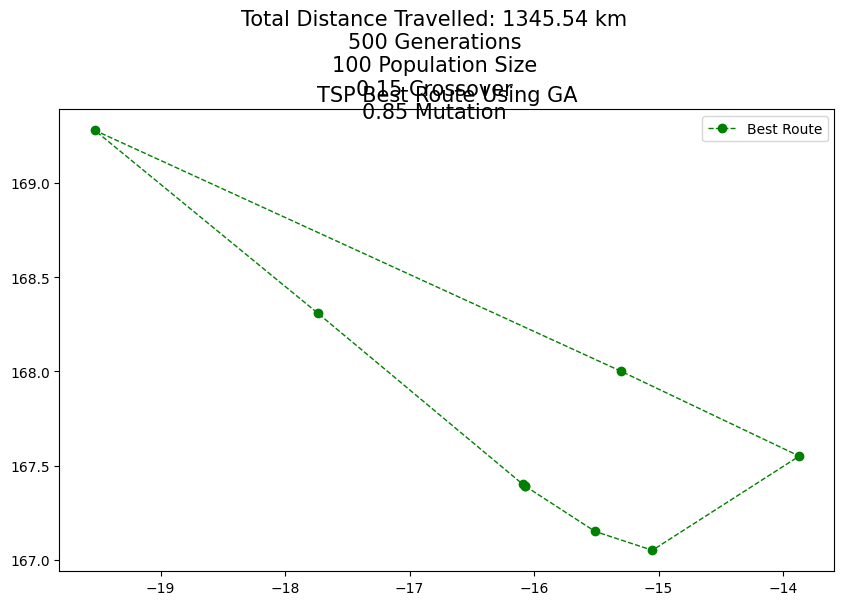

In [ ]:
fig, ax = plt.subplots()
ax.plot(lat_shortest, long_shortest, '--go', label='Best Route', linewidth=1)
plt.legend()

plt.title(label="TSP Best Route Using GA", fontsize=15, color="k")
str_params = '\n'+str(NUM_GENERATIONS)+' Generations\n'+str(POPULATION_SIZE)+' Population Size\n'+str(CROSSOVER_PROBABILITY)+' Crossover\n'+str(MUTATION_PROBABILITY)+' Mutation'
plt.suptitle("Total Distance Travelled: " + 
             str(round(population[0].fitness, 2)) + " km" + 
             str_params, fontsize=15, y = 1.047)

fig.set_size_inches(12, 10)    
plt.show()